In [1]:
# Cell 1
import os
import random
import math
import pickle
import time
import optuna
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
# Cell 2
path2data = "../../Data/russian_investment.csv"
df = pd.read_csv(path2data, sep=';')

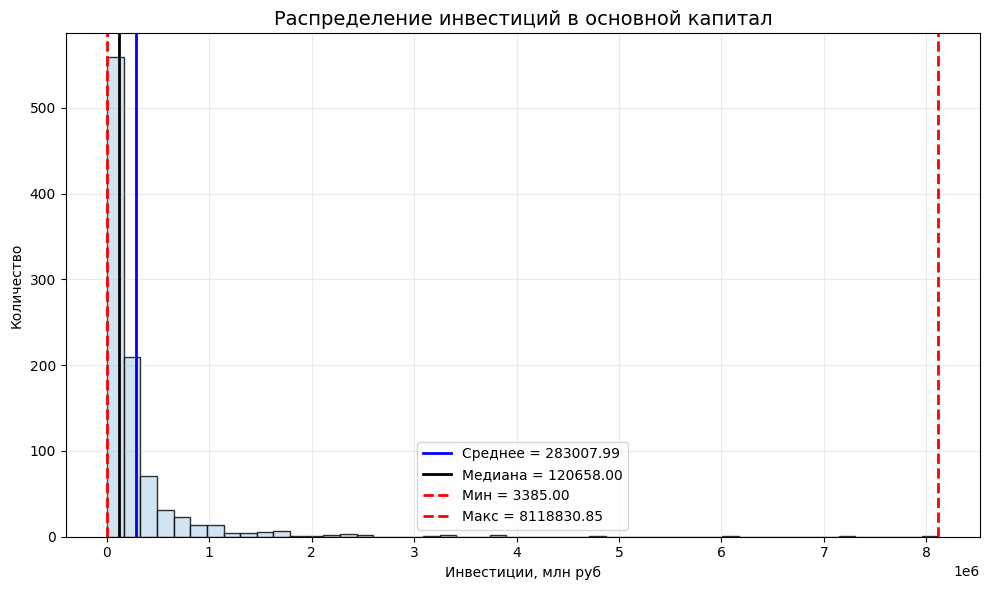

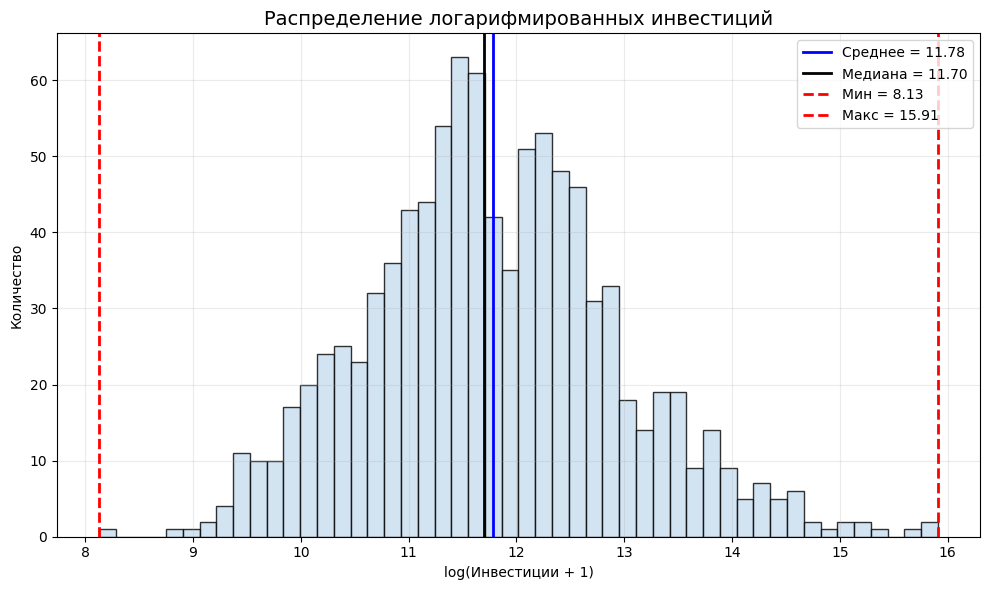

In [3]:
# Cell 3
inv_col = 'capital_investments_million_rub'
log_col = "log_" + inv_col
inv_data = df[inv_col].astype(float)
log_inv_data = df[log_col].astype(float)

def plot_distribution(data, title, xlabel):
    mean_val = data.mean()
    median_val = data.median()
    min_val = data.min()
    max_val = data.max()
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, color='#c7dcef', edgecolor='black', alpha=0.8)
    plt.axvline(mean_val, color='blue', linestyle='-', linewidth=2, label=f'Среднее = {mean_val:.2f}')
    plt.axvline(median_val, color='black', linestyle='-', linewidth=2, label=f'Медиана = {median_val:.2f}')
    plt.axvline(min_val, color='red', linestyle='--', linewidth=2, label=f'Мин = {min_val:.2f}')
    plt.axvline(max_val, color='red', linestyle='--', linewidth=2, label=f'Макс = {max_val:.2f}')
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()
    
plot_distribution(
    df[inv_col].dropna().astype(float),
    title='Распределение инвестиций в основной капитал',
    xlabel='Инвестиции, млн руб'
)
plot_distribution(
    df[log_col].dropna().astype(float),
    title='Распределение логарифмированных инвестиций',
    xlabel='log(Инвестиции + 1)'
)

In [4]:
# Cell 5
SEQ_LEN = 4
HORIZON = 3
BATCH_SIZE = 32
EPOCHS = 100

exclude_cols = [
    "year", 
    "region", 
    "district", 
    'delta_target', 
    'delta_target_percent', 
    'log_target_next_year', 
    'target_next_year',
    'capital_investments_million_rub',
    'number_of_crimes_registered_total'
]

TARGET_COL = log_col
features = [c for c in df.columns if c not in exclude_cols]

print("Число признаков:", len(features))
print("Признаки:", features)
print("TARGET_COL:", TARGET_COL)

Число признаков: 77
Признаки: ['gross_regional_product', 'population', 'unemployment_rate_15_72_years_percent', 'average_salary_rub', 'retail_trade_turnover_million_rub', 'total_money_income_million_rub', 'internal_rnd_costs_million_rub', 'gross_regional_product_per_capita_million_rub', 'investment_per_capita_million_rub', 'retail_turnover_per_capita_million_rub', 'income_per_capita_million_rub', 'military_expenditure_billion_rub', 'internal_state_debt_billion_rub', 'central_bank_average_rate_percent', 'annual_inflation_percent', 'MCFTR_average_annual_pt', 'RVI_average_annual_pt', 'RGBITR_average_annual_pt', 'brent_oil_futures_price_usd', 'gold_futures_price_usd', 'usd_to_rub_exchange_rate_rub', 'consumer_price_index', 'innovation_activity_organizations_percent', 'wholesale_trade_turnover_total', 'innovation_activity_costs_total', 'housing_stock_total', 'accounts_payable_overdue', 'life_expectancy_at_birth_total', 'patent_applications_inventions_submitted', 'students_bachelor_specialis

In [5]:
# Cell 6
df_work = df.copy()

df_all = df_work.sort_values(['region_encoded', 'year']).reset_index(drop=True)
last_year_in_data = df_all['year'].max()
print("Последний год в данных:", last_year_in_data)

records = []
regions = df_all['region_encoded'].unique()
for region in regions:
    grp = df_all[df_all['region_encoded'] == region].sort_values('year')
    years = grp['year'].values
    feat_mat = grp[features].values.astype(np.float32)
    target_vec = grp[TARGET_COL].values.astype(np.float32)
    n = len(grp)
    max_i = n - (SEQ_LEN + HORIZON)
    if max_i <= 0:
        continue
    for i in range(max_i + 1):
        x_years = years[i:i+SEQ_LEN]
        y_years = years[i+SEQ_LEN:i+SEQ_LEN+HORIZON]
        X = feat_mat[i:i+SEQ_LEN]
        Y = target_vec[i+SEQ_LEN:i+SEQ_LEN+HORIZON]
        y_last = target_vec[i+SEQ_LEN-1]
        records.append({
            'region': int(region),
            'start_year': int(x_years[0]),
            'X': X,
            'Y': Y,
            'y_last': y_last,
            'x_years': x_years,
            'y_years': y_years
        })

print("Сгенерировано окон (records):", len(records))

train_records = [r for r in records if r['y_years'][-1] < last_year_in_data]
val_records   = [r for r in records if r['y_years'][-1] == last_year_in_data]

print("Train windows:", len(train_records), "Validation (holdout) windows:", len(val_records))

Последний год в данных: 2024
Сгенерировано окон (records): 435
Train windows: 348 Validation (holdout) windows: 87


In [6]:
# Cell 6
all_X_train = np.concatenate([r['X'] for r in train_records], axis=0)
scaler_x = StandardScaler().fit(all_X_train)

all_Y_train = np.concatenate([r['Y'] for r in train_records], axis=0).reshape(-1, 1)
scaler_y = StandardScaler().fit(all_Y_train)

with open('mlp_scaler_x.pkl', 'wb') as f:
    pickle.dump(scaler_x, f)
with open('mlp_scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print("Скейлеры сохранены: mlp_scaler_x.pkl, mlp_scaler_y.pkl")

Скейлеры сохранены: mlp_scaler_x.pkl, mlp_scaler_y.pkl


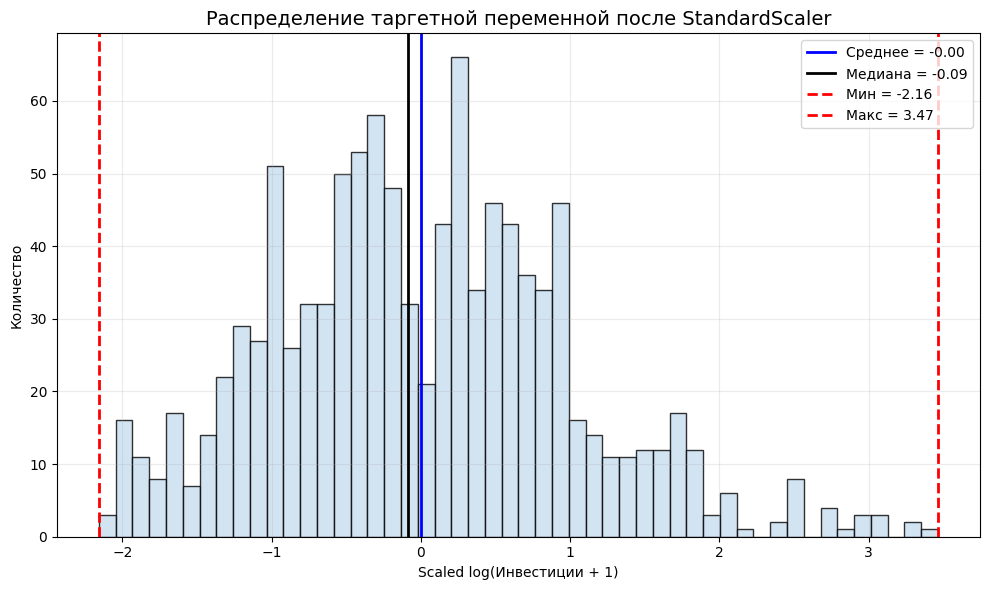

In [7]:
# Cell 7
y_train_scaled = scaler_y.transform(
    np.concatenate([r['Y'] for r in train_records], axis=0).reshape(-1, 1)
).ravel()

def plot_distribution_scaled(data, title, xlabel):
    mean_val = data.mean()
    median_val = np.median(data)
    min_val = data.min()
    max_val = data.max()

    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, color='#c7dcef', edgecolor='black', alpha=0.8)
    plt.axvline(mean_val, color='blue', linestyle='-', linewidth=2,
                label=f'Среднее = {mean_val:.2f}')
    plt.axvline(median_val, color='black', linestyle='-', linewidth=2,
                label=f'Медиана = {median_val:.2f}')
    plt.axvline(min_val, color='red', linestyle='--', linewidth=2,
                label=f'Мин = {min_val:.2f}')
    plt.axvline(max_val, color='red', linestyle='--', linewidth=2,
                label=f'Макс = {max_val:.2f}')

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()

plot_distribution_scaled(
    y_train_scaled,
    title='Распределение таргетной переменной после StandardScaler',
    xlabel='Scaled log(Инвестиции + 1)'
)

In [8]:
# Cell 9
class SeqARDataset(Dataset):
    def __init__(self, recs, scaler_x, scaler_y):
        self.recs = recs
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y

    def __len__(self):
        return len(self.recs)

    def __getitem__(self, idx):
        r = self.recs[idx]

        X = r['X']
        Xs = self.scaler_x.transform(X.reshape(-1, X.shape[1])).reshape(X.shape)

        Y = r['Y'].reshape(-1, 1)
        Ys = self.scaler_y.transform(Y).reshape(-1)

        return {
            'X': torch.tensor(Xs, dtype=torch.float32),
            'Y': torch.tensor(Ys, dtype=torch.float32),
            'region': int(r['region'])
        }


train_ds = SeqARDataset(train_records, scaler_x, scaler_y)
val_ds   = SeqARDataset(val_records, scaler_x, scaler_y)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False) if len(train_ds)>0 else None
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False) if len(val_ds)>0 else None

print("Train batches:", len(train_loader) if train_loader is not None else 0,
      "Val batches:", len(val_loader) if val_loader is not None else 0)

Train batches: 11 Val batches: 3


In [9]:
# Cell 10
def torch_loss_mean(pred, target, loss_type, huber_delta=1.0):
    if loss_type == "mae":
        return torch.mean(torch.abs(pred - target))

    elif loss_type == "mse":
        return torch.mean((pred - target) ** 2)

    elif loss_type == "huber":
        err = pred - target
        abs_err = torch.abs(err)
        quadratic = 0.5 * err ** 2
        linear = huber_delta * (abs_err - 0.5 * huber_delta)
        loss_elem = torch.where(abs_err <= huber_delta, quadratic, linear)
        return loss_elem.mean()

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

def np_loss_per_horizon(y_true, y_pred, loss_type, huber_delta=1.0):
    err = y_pred - y_true

    if loss_type == "mae":
        return np.mean(np.abs(err), axis=0)

    elif loss_type == "mse":
        return np.mean(err ** 2, axis=0)

    elif loss_type == "huber":
        abs_err = np.abs(err)
        quadratic = 0.5 * err ** 2
        linear = huber_delta * (abs_err - 0.5 * huber_delta)
        loss_elem = np.where(abs_err <= huber_delta, quadratic, linear)
        return np.mean(loss_elem, axis=0)

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

In [10]:
# Cell 10
def validate_full(model, loader, scaler_y, loss_type, huber_delta=1.0):
    model.eval()
    if loader is None:
        return None, None

    ys_scaled, yps_scaled = [], []

    with torch.no_grad():
        for batch in loader:
            X = batch["X"].to(device)
            Y = batch["Y"].to(device)
            region = batch.get("region", None)
            if isinstance(region, torch.Tensor):
                region = region.to(device)
            pred = model(X, region=region)


            ys_scaled.append(Y.cpu().numpy())
            yps_scaled.append(pred.cpu().numpy())

    ys_scaled = np.concatenate(ys_scaled, axis=0)
    yps_scaled = np.concatenate(yps_scaled, axis=0)

    n, h = ys_scaled.shape
    ys_log = scaler_y.inverse_transform(ys_scaled.reshape(-1, 1)).reshape(n, h)
    yps_log = scaler_y.inverse_transform(yps_scaled.reshape(-1, 1)).reshape(n, h)

    loss_per_h = np_loss_per_horizon(
        ys_scaled, yps_scaled, loss_type, huber_delta
    )
    val_loss = float(np.mean(loss_per_h))

    mae_log = np.mean(np.abs(ys_log - yps_log), axis=0)
    mse_log = np.mean((ys_log - yps_log) ** 2, axis=0)
    if huber_delta is None:
        huber_delta = 1.0
    huber_log = np_loss_per_horizon(
        ys_log, yps_log, loss_type="huber", huber_delta=huber_delta
    )
    r2_log = np.array(
        [r2_score(ys_log[:, t], yps_log[:, t]) for t in range(h)]
    )

    ys_real = np.expm1(ys_log)
    yps_real = np.expm1(yps_log)

    mae_real = np.mean(np.abs(ys_real - yps_real), axis=0)
    mse_real = np.mean((ys_real - yps_real) ** 2, axis=0)
    rmse_real = np.sqrt(mse_real)
    if huber_delta is None:
        huber_delta = 1.0
    huber_real = np_loss_per_horizon(
        ys_real, yps_real, loss_type="huber", huber_delta=huber_delta
    )

    eps = 1e-8
    mape_real, smape_real = [], []

    for t in range(h):
        yt, yp = ys_real[:, t], yps_real[:, t]
        nz = yt != 0

        mape_real.append(
            np.mean(np.abs((yt[nz] - yp[nz]) / yt[nz])) * 100.0
            if nz.any()
            else np.nan
        )

        smape_real.append(
            np.mean(
                np.abs(yp - yt) /
                ((np.abs(yt) + np.abs(yp)) / 2 + eps)
            ) * 100.0
        )

    metrics = {
        "LOSS_stand": loss_per_h,

        "MAE_log": mae_log,
        "MSE_log": mse_log,
        "HUBER_log": huber_log,
        "R2_log": r2_log,

        "MAE_real": mae_real,
        "MSE_real": mse_real,
        "RMSE_real": rmse_real,
        "HUBER_real": huber_real,
        "MAPE_real": np.array(mape_real),
        "SMAPE_real": np.array(smape_real),
    }

    return val_loss, metrics

In [11]:
# Cell 12
def train_epoch_with_options(
    model,
    loader,
    optimizer,
    loss_type,
    huber_delta=1.0,
    grad_clip=None,
):
    model.train()
    total_loss, n = 0.0, 0

    for batch in loader:
        X = batch["X"].to(device)
        Y = batch["Y"].to(device)
        region = batch["region"].to(device)

        optimizer.zero_grad()
        pred = model(X, region=region)
        loss = torch_loss_mean(pred, Y, loss_type, huber_delta)
        loss.backward()

        if grad_clip and grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item() * X.size(0)
        n += X.size(0)

    return total_loss / max(1, n)

In [12]:
# Cell 13
class FeedForwardAR(nn.Module):
    def __init__(
        self,
        n_features,
        seq_len,
        horizon,
        hidden_sizes=(128, 64),
        dropout=0.1,
        region_emb_size=0
    ):
        super().__init__()

        self.seq_len = seq_len
        self.horizon = horizon
        self.region_emb_size = region_emb_size

        if region_emb_size > 0:
            self.region_emb = nn.Embedding(100, region_emb_size)
        else:
            self.region_emb = None

        input_dim = n_features * seq_len
        if region_emb_size > 0:
            input_dim += region_emb_size

        layers = []
        prev_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, horizon))

        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x, region=None):
        B = x.size(0)
        x = x.reshape(B, -1)

        if self.region_emb is not None:
            if region is None:
                reg_emb = torch.zeros(B, self.region_emb_size, device=x.device)
            else:
                reg_emb = self.region_emb(region.long().to(x.device))
            x = torch.cat([x, reg_emb], dim=1)

        out = self.net(x)
        return out

test_model = FeedForwardAR(n_features=78, seq_len=4, horizon=3)
print(test_model)
total_params = sum(p.numel() for p in test_model.parameters())
print(f"Total parameters: {total_params}")

trainable_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

hidden_sizes_map = {
        "64": (64,),
        "128": (128,),
        "128-64": (128, 64),
        "256-128": (256, 128),
        "256-128-64": (256, 128, 64),
}

FeedForwardAR(
  (net): Sequential(
    (0): Linear(in_features=312, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)
Total parameters: 48515
Trainable parameters: 48515


In [13]:
# Cell 14
def create_model_from_cfg(cfg, state_dict=None, device=device):
    model = FeedForwardAR(
        n_features=len(features),
        seq_len=SEQ_LEN,
        horizon=HORIZON,
        hidden_sizes=hidden_sizes_map[cfg['hidden_sizes_key']],
        dropout=cfg["dropout"],
        region_emb_size=cfg.get("region_emb_size", 0),
    ).to(device)
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

In [14]:
# Cell 15
GRID_EPOCHS = EPOCHS
RANDOM_SEED = SEED

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "adamw", "rmsprop"])

    hidden_sizes_key = trial.suggest_categorical("hidden_sizes", ["64", "128", "128-64", "256-128", "256-128-64"])
    
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    region_emb_size = trial.suggest_categorical("region_emb_size", [0, 8, 16, 32])
    grad_clip = trial.suggest_float("grad_clip", 0.0, 5.0)

    lr_scheduler = trial.suggest_categorical("lr_scheduler", ["none", "step", "cosine"])
    step_size = trial.suggest_int("step_size", 10, max(10, GRID_EPOCHS//2))
    gamma = trial.suggest_float("gamma", 0.1, 0.9)
    loss_type = trial.suggest_categorical("loss_type", ["mae", "mse", "huber"])
    huber_delta = (trial.suggest_float("huber_delta", 0.1, 5.0) if loss_type == "huber" else None)
    
    hidden_sizes = hidden_sizes_map[hidden_sizes_key]
    
    cfg = {
        "lr": lr,
        "weight_decay": weight_decay,
        "optimizer": optimizer_name,

        "hidden_sizes_key": hidden_sizes_key,
        "dropout": dropout,
        "region_emb_size": region_emb_size,
        "grad_clip": grad_clip,
        
        "lr_scheduler": lr_scheduler,
        "step_size": step_size,
        "gamma": gamma,
        "loss_type": loss_type,
        "huber_delta": huber_delta,
        
    }

    model = create_model_from_cfg(cfg)

    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = None
    if lr_scheduler == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=step_size, gamma=gamma
        )
    elif lr_scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=max(1, GRID_EPOCHS)
        )

    best_val_loss = float("inf")
    best_state_dict = None
    best_cfg = None
    best_epoch = None
    epoch_history = []

    patience = 15
    min_delta = 1e-4
    no_improve_steps = 0

    for epoch in range(1, GRID_EPOCHS + 1):

        train_loss = train_epoch_with_options(
            model,
            train_loader,
            optimizer,
            loss_type,
            huber_delta=huber_delta,
            grad_clip=grad_clip,
        )

        if scheduler is not None:
            scheduler.step()

        val_loss_full, metrics = validate_full(
            model,
            val_loader,
            scaler_y,
            loss_type=loss_type,
            huber_delta=huber_delta,
        )

        epoch_history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss_full": val_loss_full,
            **{k: v.tolist() for k, v in metrics.items()}
        })

        if val_loss_full < best_val_loss - min_delta:
            best_val_loss = val_loss_full
            no_improve_steps = 0

            best_state_dict = {
                k: v.detach().cpu().clone()
                for k, v in model.state_dict().items()
            }
            best_cfg = cfg.copy()
            best_epoch = epoch
        else:
            no_improve_steps += 1

        trial.report(val_loss_full, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if epoch == 1 or epoch % 10 == 0 or epoch == GRID_EPOCHS:
            print(
                f"[trial {trial.number}] "
                f"epoch {epoch}/{GRID_EPOCHS} "
                f"train={train_loss:.6f} "
                f"val_full={val_loss_full:.6f} "
                f"no_improve={no_improve_steps}/{patience}"
            )

        if no_improve_steps >= patience:
            print(
                f"[trial {trial.number}] "
                f"Early stopping at epoch {epoch} "
                f"(best_val={best_val_loss:.6f})"
            )
            break

    trial.set_user_attr("best_epoch", best_epoch)
    trial.set_user_attr("best_cfg", best_cfg)
    trial.set_user_attr("best_state_dict", best_state_dict)
    trial.set_user_attr("epoch_metrics", epoch_history)

    return float(best_val_loss)

In [15]:
# Cell 16
study_name = f"ar_feedforward_optuna_{int(time.time())}"

study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
    pruner=optuna.pruners.MedianPruner(
        n_warmup_steps=max(1, GRID_EPOCHS // 10)
    )
)

N_TRIALS = 200

print("Starting Optuna study:", study_name)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best = study.best_trial

torch.save(
    {
        "cfg": best.user_attrs["best_cfg"],
        "state_dict": best.user_attrs["best_state_dict"],
        "epoch_metrics": best.user_attrs["epoch_metrics"],
        "best_val_loss": best.value,
        "best_epoch": best.user_attrs["best_epoch"]

    },
    "best_mlp.pt"
)
print(f"BEST EPOCH: {best.user_attrs['best_epoch']}")

[I 2025-12-20 12:19:56,628] A new study created in memory with name: ar_feedforward_optuna_1766215196


Starting Optuna study: ar_feedforward_optuna_1766215196


  0%|          | 0/200 [00:00<?, ?it/s]

[trial 0] epoch 1/100 train=0.690758 val_full=0.747541 no_improve=0/15
[trial 0] epoch 10/100 train=0.154281 val_full=0.304562 no_improve=0/15
[trial 0] epoch 20/100 train=0.079983 val_full=0.236270 no_improve=0/15
[trial 0] epoch 30/100 train=0.048349 val_full=0.217229 no_improve=0/15
[trial 0] epoch 40/100 train=0.038931 val_full=0.203269 no_improve=0/15
[trial 0] epoch 50/100 train=0.036040 val_full=0.198047 no_improve=0/15
[trial 0] epoch 60/100 train=0.032432 val_full=0.193114 no_improve=0/15
[trial 0] epoch 70/100 train=0.027893 val_full=0.188022 no_improve=0/15
[trial 0] epoch 80/100 train=0.029205 val_full=0.185835 no_improve=0/15
[trial 0] epoch 90/100 train=0.026149 val_full=0.184077 no_improve=1/15
[trial 0] epoch 100/100 train=0.024343 val_full=0.182874 no_improve=0/15
[I 2025-12-20 12:20:10,672] Trial 0 finished with value: 0.18287436664104462 and parameters: {'lr': 5.6115164153345e-05, 'weight_decay': 0.0005669849511478851, 'optimizer': 'adam', 'hidden_sizes': '128-64', '

Loaded checkpoint: best_mlp.pt
Epochs saved: 92
Best epoch: 77

Available metric keys per epoch:
  epoch: scalar
  train_loss: scalar
  val_loss_full: scalar
  LOSS_stand: list(len=3)
  MAE_log: list(len=3)
  MSE_log: list(len=3)
  HUBER_log: list(len=3)
  R2_log: list(len=3)
  MAE_real: list(len=3)
  MSE_real: list(len=3)
  RMSE_real: list(len=3)
  HUBER_real: list(len=3)
  MAPE_real: list(len=3)
  SMAPE_real: list(len=3)


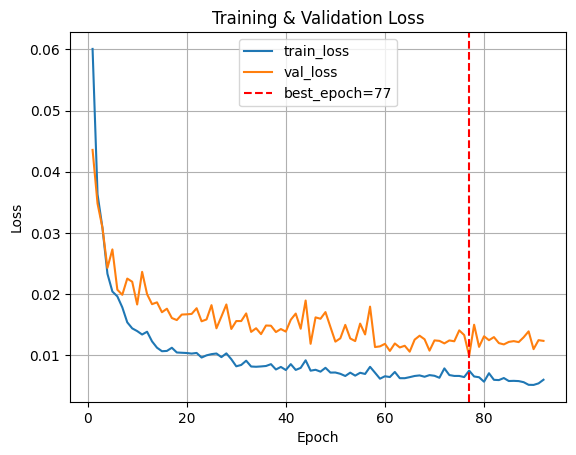


Plotting per-horizon metrics:


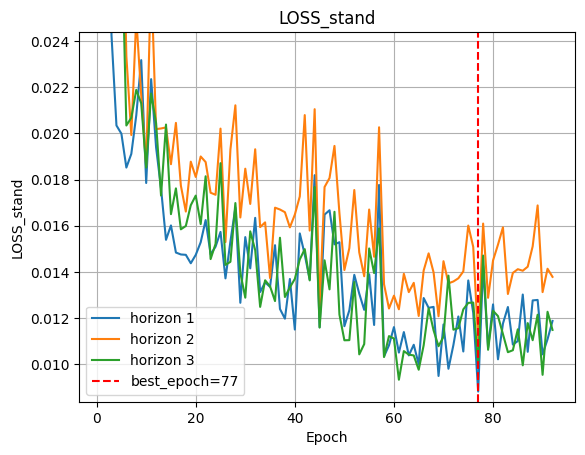

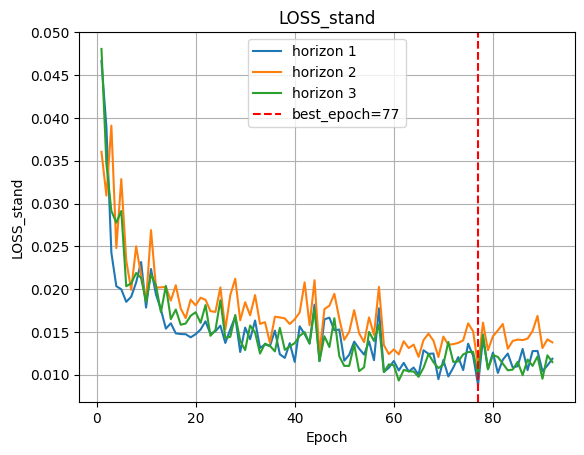

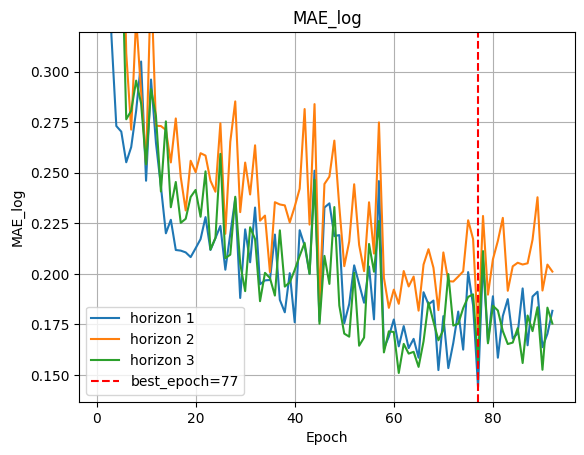

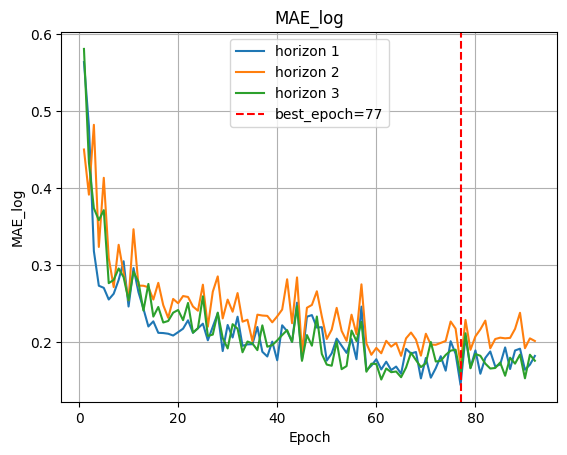

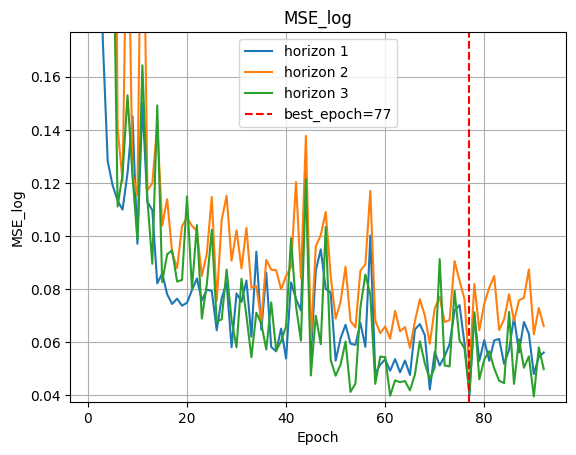

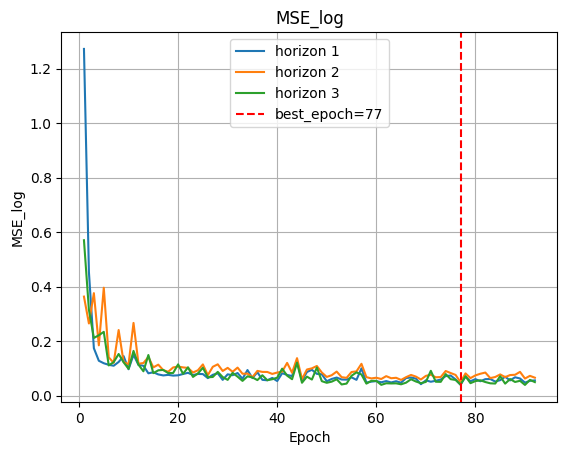

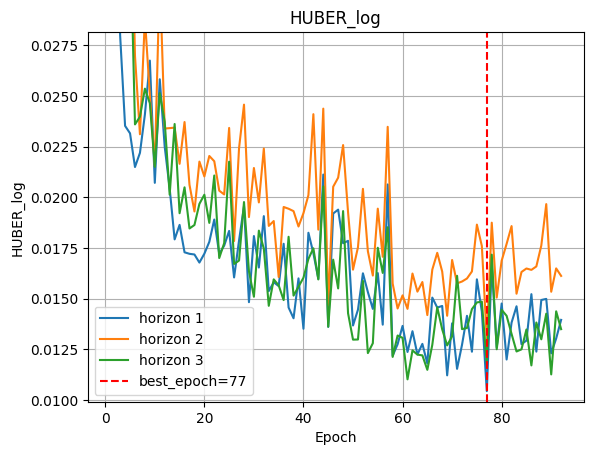

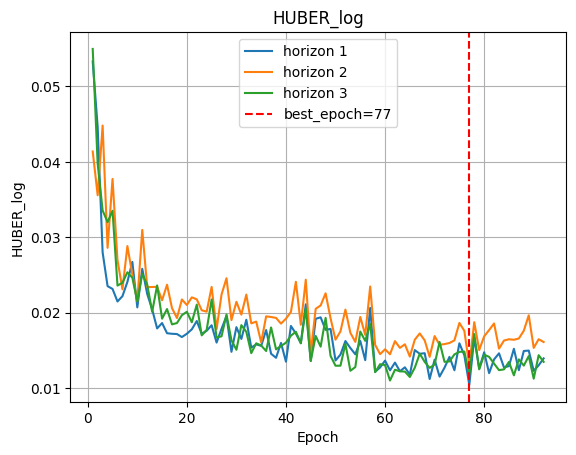

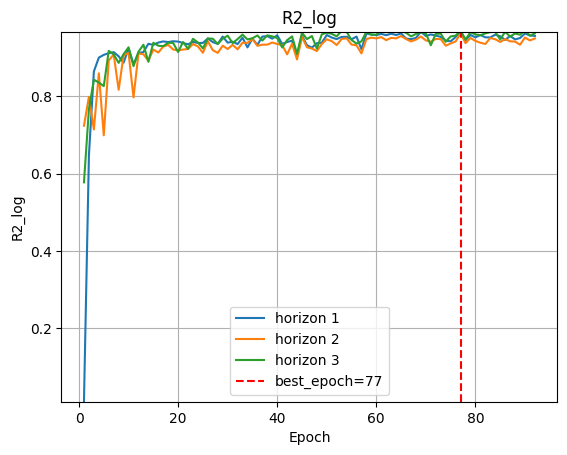

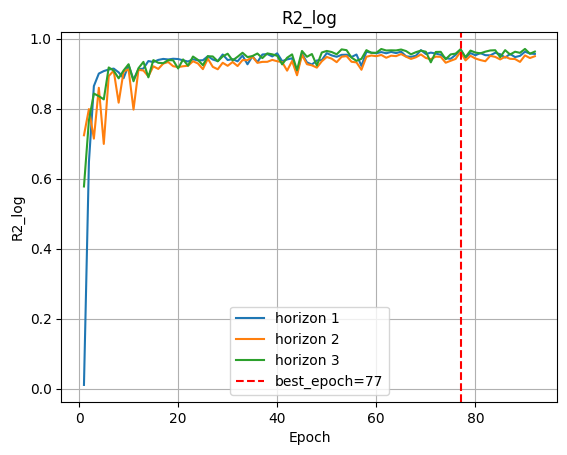

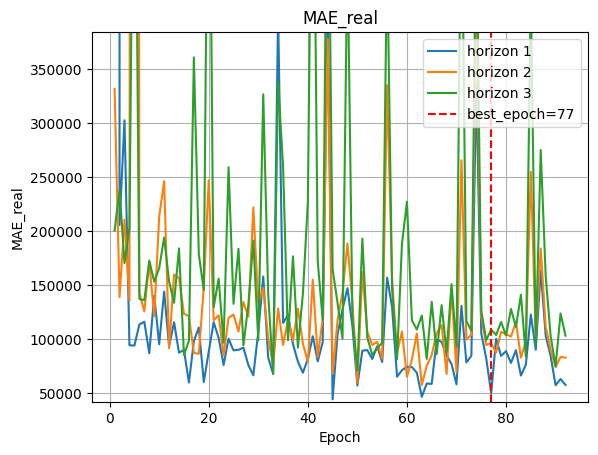

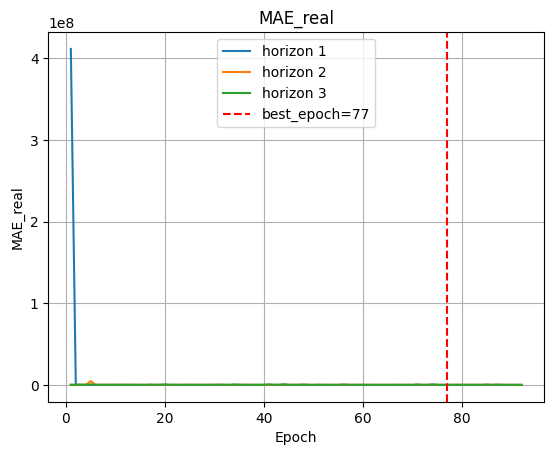

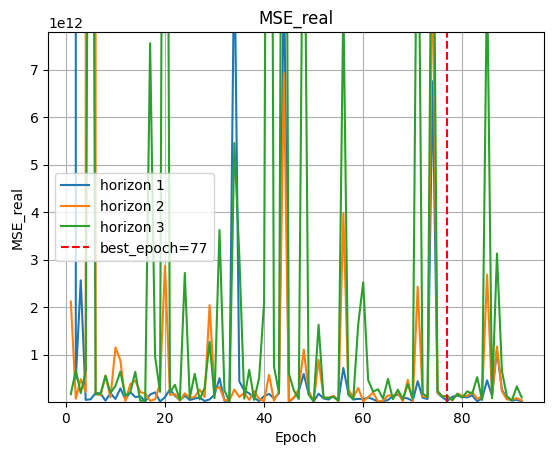

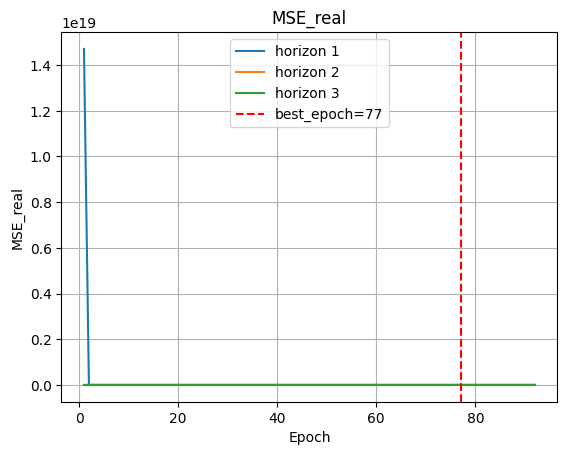

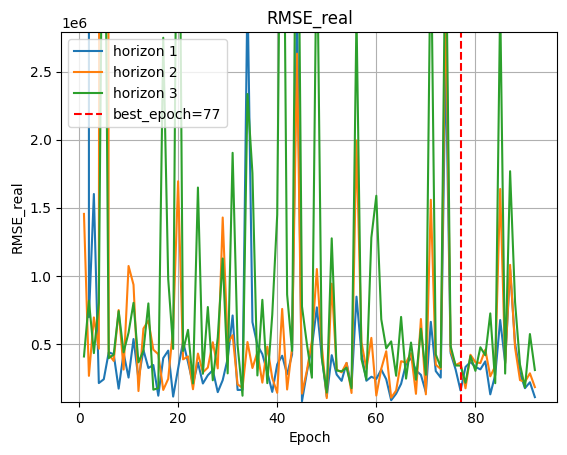

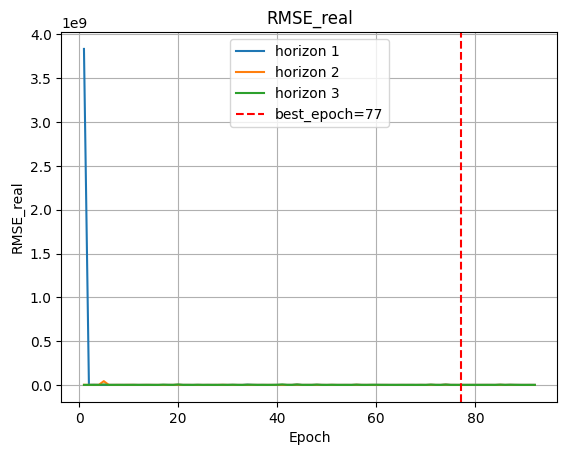

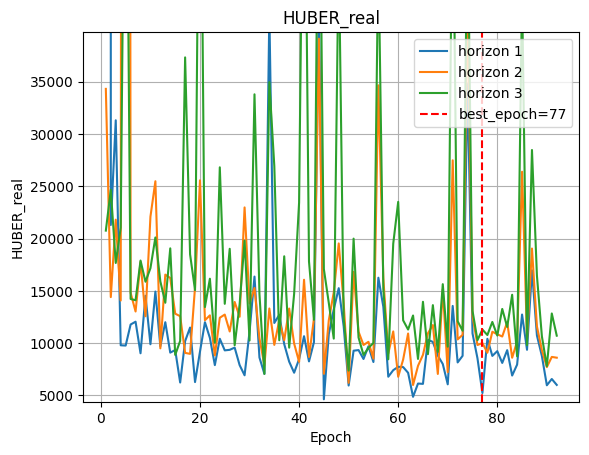

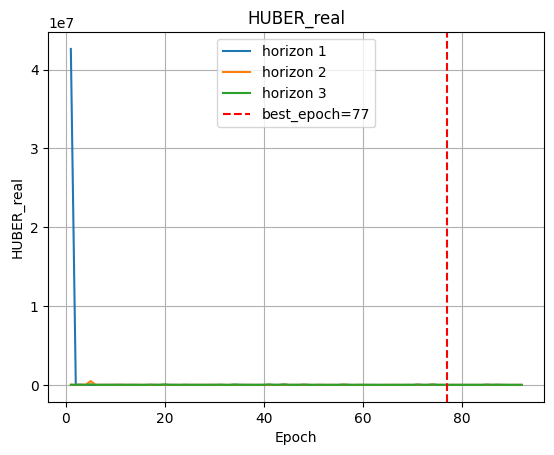

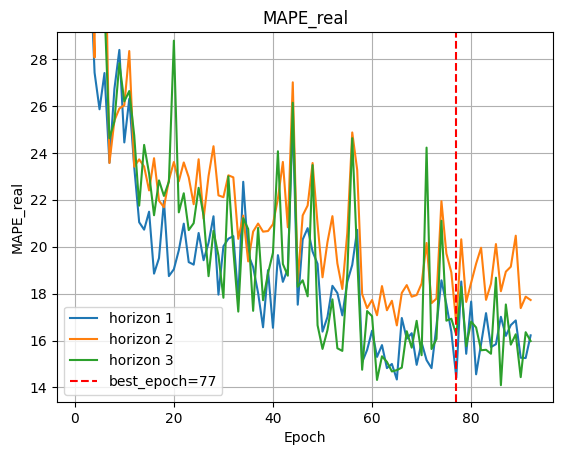

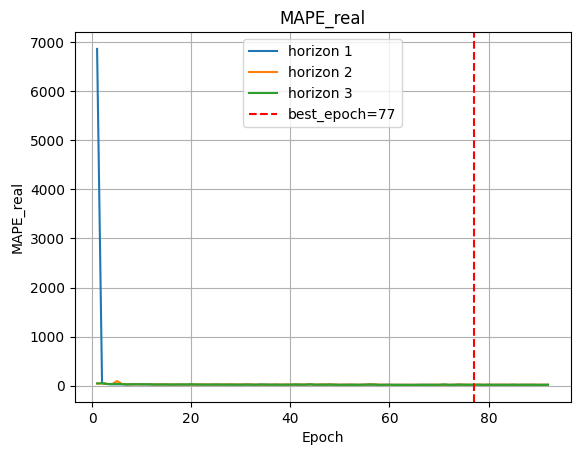

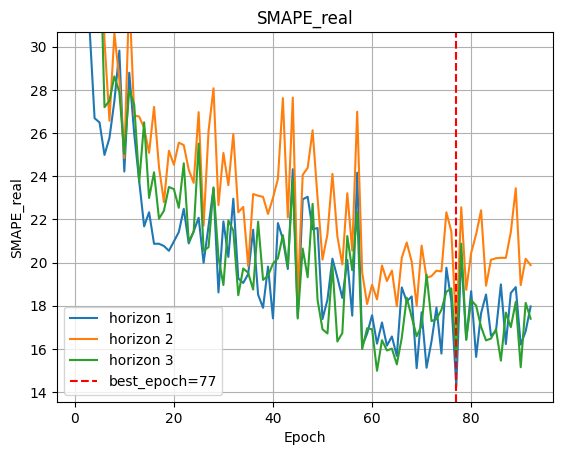

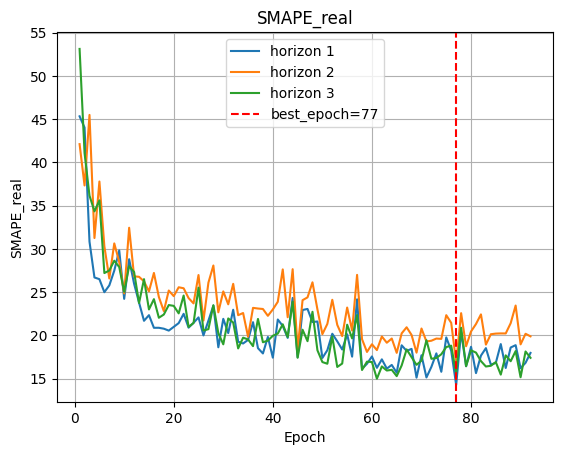

In [16]:
# Cell 16
CKPT_PATH = "best_mlp.pt"

ckpt = torch.load(CKPT_PATH, map_location="cpu")
epoch_history = ckpt["epoch_metrics"]
best_epoch = ckpt.get("best_epoch", None)

print(f"Loaded checkpoint: {CKPT_PATH}")
print(f"Epochs saved: {len(epoch_history)}")
print(f"Best epoch: {best_epoch}")

print("\nAvailable metric keys per epoch:")
for k in epoch_history[0].keys():
    v = epoch_history[0][k]
    if isinstance(v, list):
        print(f"  {k}: list(len={len(v)})")
    else:
        print(f"  {k}: scalar")

history = defaultdict(list)

for row in epoch_history:
    for k, v in row.items():
        history[k].append(v)

epochs = history["epoch"]

plt.figure()
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss_full"], label="val_loss")

if best_epoch is not None:
    plt.axvline(best_epoch, color='red', linestyle='--', label=f"best_epoch={best_epoch}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()

def plot_per_horizon(metric_name, values, best_epoch=None, ylim_mode="auto"):
    arr = np.array(values)
    H = arr.shape[1]

    plt.figure()

    for h in range(H):
        plt.plot(epochs, arr[:, h], label=f"horizon {h+1}")

    if ylim_mode == "auto":
        ymax = np.nanpercentile(arr, 95)
        ymin = np.nanmin(arr)
        plt.ylim(bottom=ymin * 0.95, top=ymax)
    elif isinstance(ylim_mode, (int, float)):
        plt.ylim(top=float(ylim_mode))

    if best_epoch is not None:
        plt.axvline(
            best_epoch,
            color='red',
            linestyle='--',
            label=f"best_epoch={best_epoch}"
        )

    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(metric_name)
    plt.legend()
    plt.grid(True)
    if ylim_mode is not None:
        plt.savefig(f"{metric_name} by Horizon ylim")
    else:
        plt.savefig(f"{metric_name} by Horizon")
    plt.show()

print("\nPlotting per-horizon metrics:")

for k, v in history.items():
    if k in ["epoch", "train_loss", "val_loss_full"]:
        continue

    if isinstance(v[0], list):
        try:
            plot_per_horizon(
                k, v,
                best_epoch=best_epoch,
            )
            plot_per_horizon(
                k, v,
                best_epoch=best_epoch,
                ylim_mode=None
            )
            
        except Exception as e:
            print(f"  Skipped {k}: {e}")

In [17]:
# Cell 17
ckpt = torch.load("best_mlp.pt", map_location=device)
model = create_model_from_cfg(
    ckpt["cfg"],
    state_dict=ckpt["state_dict"]
)
model.eval()

FeedForwardAR(
  (region_emb): Embedding(100, 16)
  (net): Sequential(
    (0): Linear(in_features=324, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.08855586500061174, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.08855586500061174, inplace=False)
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [18]:
# Cell 18
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 118083
Trainable parameters: 118083


In [19]:
# Cell 19
model.eval()

if val_loader is None:
    print("No validation loader — ничего считать.")
else:
    ys_scaled, yps_scaled = [], []

    with torch.no_grad():
        for batch in val_loader:
            X = batch["X"].to(device)
            Y = batch["Y"].to(device)
            region = batch.get("region", None)
            if isinstance(region, torch.Tensor):
                region = region.to(device)
            pred = model(X, region=region)

            ys_scaled.append(Y.cpu().numpy())
            yps_scaled.append(pred.cpu().numpy())

    ys_scaled = np.concatenate(ys_scaled, axis=0)
    yps_scaled = np.concatenate(yps_scaled, axis=0)

    n, h = ys_scaled.shape
    ys_log = scaler_y.inverse_transform(ys_scaled.reshape(-1, 1)).reshape(n, h)
    yps_log = scaler_y.inverse_transform(yps_scaled.reshape(-1, 1)).reshape(n, h)

    mae_log = np_loss_per_horizon(ys_log, yps_log, loss_type="mae")
    mse_log = np_loss_per_horizon(ys_log, yps_log, loss_type="mse")
    if ckpt['cfg']['huber_delta'] is None:
        huber_delta = 1.0
    else:
        huber_delta = ckpt['cfg']['huber_delta']
    huber_log = np_loss_per_horizon(
        ys_log, yps_log, loss_type="huber", huber_delta=huber_delta
    )
    r2_log = np.array([
        r2_score(ys_log[:, t], yps_log[:, t]) for t in range(h)
    ])

    ys_real = np.expm1(ys_log)
    yps_real = np.expm1(yps_log)

    mae_real = np_loss_per_horizon(ys_real, yps_real, loss_type="mae")
    mse_real = np_loss_per_horizon(ys_real, yps_real, loss_type="mse")
    rmse_real = np.sqrt(mse_real)
    huber_real = np_loss_per_horizon(
        ys_real, yps_real, loss_type="huber", huber_delta=huber_delta
    )

    eps = 1e-8
    mape_real, smape_real = [], []

    for t in range(h):
        yt, yp = ys_real[:, t], yps_real[:, t]
        nz = yt != 0

        mape_real.append(
            np.mean(np.abs((yt[nz] - yp[nz]) / yt[nz])) * 100.0
            if nz.any()
            else np.nan
        )

        smape_real.append(
            np.mean(
                np.abs(yp - yt) /
                ((np.abs(yt) + np.abs(yp)) / 2 + eps)
            ) * 100.0
        )

    mape_real = np.array(mape_real)
    smape_real = np.array(smape_real)

    for t in range(h):
        print(
            f"Год t+{t+1}: "
            f"MAE_log={mae_log[t]:.6f}, "
            f"MSE_log={mse_log[t]:.6f}, "
            f"R2_log={r2_log[t]:.6f}, "
            f"HUBER_log={huber_log[t]:.6f} | "
            f"MAE_real={mae_real[t]:.2f}, "
            f"MSE_real={mse_real[t]:.2f}, "
            f"RMSE_real={rmse_real[t]:.2f}, "
            f"HUBER_real={huber_real[t]:.2f}, "
            f"MAPE_real={mape_real[t]:.2f}%, "
            f"SMAPE_real={smape_real[t]:.2f}%"
        )

Год t+1: MAE_log=0.144002, MSE_log=0.039939, R2_log=0.968952, HUBER_log=0.010430 | MAE_real=50429.95, MSE_real=24830134272.00, RMSE_real=157575.81, HUBER_real=5220.01, MAPE_real=14.41%, SMAPE_real=14.26%
Год t+2: MAE_log=0.170338, MSE_log=0.049212, R2_log=0.962657, HUBER_log=0.012987 | MAE_real=96636.09, MSE_real=131425419264.00, RMSE_real=362526.44, HUBER_real=10002.82, MAPE_real=16.73%, SMAPE_real=16.88%
Год t+3: MAE_log=0.156714, MSE_log=0.040860, R2_log=0.969754, HUBER_log=0.011767 | MAE_real=109084.36, MSE_real=116290600960.00, RMSE_real=341014.06, HUBER_real=11291.34, MAPE_real=16.25%, SMAPE_real=15.56%


In [20]:
# Cell 20
idx_to_name_path = "../../Data/idx_to_name.pkl"
idx_to_name = {}
if os.path.exists(idx_to_name_path):
    with open(idx_to_name_path, "rb") as f:
        d = pickle.load(f)
    idx_to_name = d.get("region", {})
    print(f"Loaded region mapping from {idx_to_name_path}, entries={len(idx_to_name)}")
else:
    print(f"Warning: {idx_to_name_path} not found — регионы будут показаны как индексы.")

need_rebuild = not all(var in globals() for var in ["ys_all_scaled", "yps_all_scaled", "regions_all"])
if need_rebuild:
    if 'val_loader' not in globals() or val_loader is None:
        raise RuntimeError("val_loader отсутствует — выполните этап валидации или обеспечьте val_loader.")
    print("Пересобираю ys_all_scaled, yps_all_scaled, regions_all из val_loader ...")

    ys_list, yps_list, regions_list = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            X = batch['X'].to(device)
            Y = batch['Y'].to(device)
            region = batch['region']
            pred = model(X, region=region)
            ys_list.append(Y.cpu().numpy())
            yps_list.append(pred.cpu().numpy())
            if isinstance(region, torch.Tensor):
                regions_list.append(region.cpu().numpy())
            else:
                regions_list.append(np.array(region))

    ys_all_scaled = np.concatenate(ys_list, axis=0)
    yps_all_scaled = np.concatenate(yps_list, axis=0)
    regions_all = np.concatenate(regions_list, axis=0)
    print(f"Собрано: окна={ys_all_scaled.shape[0]}, horizon={ys_all_scaled.shape[1]}")

n, h = ys_all_scaled.shape
assert yps_all_scaled.shape == (n, h)
assert regions_all.shape[0] == n

ys_all_log = scaler_y.inverse_transform(ys_all_scaled.reshape(-1,1)).reshape(n,h)
yps_all_log = scaler_y.inverse_transform(yps_all_scaled.reshape(-1,1)).reshape(n,h)

ys_all_real = np.expm1(ys_all_log)
yps_all_real = np.expm1(yps_all_log)

region_metrics = {}
unique_regions = np.unique(regions_all)
eps = 1e-8

for reg in unique_regions:
    mask = regions_all == reg
    cnt = int(mask.sum())
    if cnt == 0:
        continue

    ys_r_log, yps_r_log = ys_all_log[mask], yps_all_log[mask]
    ys_r_real, yps_r_real = ys_all_real[mask], yps_all_real[mask]

    mae_log_r = np_loss_per_horizon(ys_r_log, yps_r_log, loss_type="mae")
    mse_log_r = np_loss_per_horizon(ys_r_log, yps_r_log, loss_type="mse")
    if ckpt['cfg']['huber_delta'] is None:
        huber_delta = 1.0
    else:
        huber_delta = ckpt['cfg']['huber_delta']
    huber_log_r = np_loss_per_horizon(ys_r_log, yps_r_log, loss_type="huber", huber_delta=huber_delta)

    mae_real_r = np_loss_per_horizon(ys_r_real, yps_r_real, loss_type="mae")
    mse_real_r = np_loss_per_horizon(ys_r_real, yps_r_real, loss_type="mse")
    rmse_real_r = np.sqrt(mse_real_r)
    huber_real_r = np_loss_per_horizon(ys_r_real, yps_r_real, loss_type="huber", huber_delta=huber_delta)

    mape_real_r, smape_real_r = [], []
    for t in range(h):
        yt, yp = ys_r_real[:,t], yps_r_real[:,t]
        nz = yt != 0
        mape_real_r.append(np.mean(np.abs((yt[nz]-yp[nz])/yt[nz]))*100.0 if nz.any() else np.nan)
        smape_real_r.append(np.mean(np.abs(yp-yt)/((np.abs(yt)+np.abs(yp))/2 + eps))*100.0)
    mape_real_r, smape_real_r = np.array(mape_real_r), np.array(smape_real_r)

    region_metrics[int(reg)] = {
        'count': cnt,
        'MAE_log': mae_log_r,
        'MSE_log': mse_log_r,
        'HUBER_log': huber_log_r,
        'MAE_real': mae_real_r,
        'MSE_real': mse_real_r,
        'RMSE_real': rmse_real_r,
        'HUBER_real': huber_real_r,
        'MAPE_real': mape_real_r,
        'SMAPE_real': smape_real_r
    }

print("=== Метрики по регионам (название / индекс) ===")
for reg in sorted(region_metrics.keys()):
    name = idx_to_name.get(reg, None)
    title = f"{name} (idx={reg})" if name else f"idx={reg}"
    print(f"Регион: {title}  — окна: {region_metrics[reg]['count']}")
    for t in range(h):
        print(
            f"  t+{t+1}: "
            f"MAE_log={region_metrics[reg]['MAE_log'][t]:.6f}, "
            f"MSE_log={region_metrics[reg]['MSE_log'][t]:.6f}, "
            f"HUBER_log={region_metrics[reg]['HUBER_log'][t]:.6f} | "
            f"MAE_real={region_metrics[reg]['MAE_real'][t]:.2f}, "
            f"MSE_real={region_metrics[reg]['MSE_real'][t]:.2f}, "
            f"RMSE_real={region_metrics[reg]['RMSE_real'][t]:.2f}, "
            f"HUBER_real={region_metrics[reg]['HUBER_real'][t]:.2f}, "
            f"MAPE_real={region_metrics[reg]['MAPE_real'][t]:.2f}%, "
            f"SMAPE_real={region_metrics[reg]['SMAPE_real'][t]:.2f}%"
        )
    print("")

Loaded region mapping from ../../Data/idx_to_name.pkl, entries=87
Пересобираю ys_all_scaled, yps_all_scaled, regions_all из val_loader ...
Собрано: окна=87, horizon=3
=== Метрики по регионам (название / индекс) ===
Регион: Алтайский край (idx=0)  — окна: 1
  t+1: MAE_log=0.135980, MSE_log=0.018490, HUBER_log=0.008718 | MAE_real=21278.09, MSE_real=452757280.00, RMSE_real=21278.09, HUBER_real=2202.50, MAPE_real=14.57%, SMAPE_real=13.58%
  t+2: MAE_log=0.092537, MSE_log=0.008563, HUBER_log=0.004282 | MAE_real=18000.03, MSE_real=324001120.00, RMSE_real=18000.03, HUBER_real=1863.18, MAPE_real=9.70%, SMAPE_real=9.25%
  t+3: MAE_log=0.012908, MSE_log=0.000167, HUBER_log=0.000083 | MAE_real=2988.44, MSE_real=8930759.00, RMSE_real=2988.44, HUBER_real=309.33, MAPE_real=1.28%, SMAPE_real=1.29%

Регион: Амурская область (idx=1)  — окна: 1
  t+1: MAE_log=0.086376, MSE_log=0.007461, HUBER_log=0.003730 | MAE_real=40385.69, MSE_real=1631003776.00, RMSE_real=40385.69, HUBER_real=4180.33, MAPE_real=8.28

Baseline MAE (real, averaged over все окна и горизонты): 85383.460938


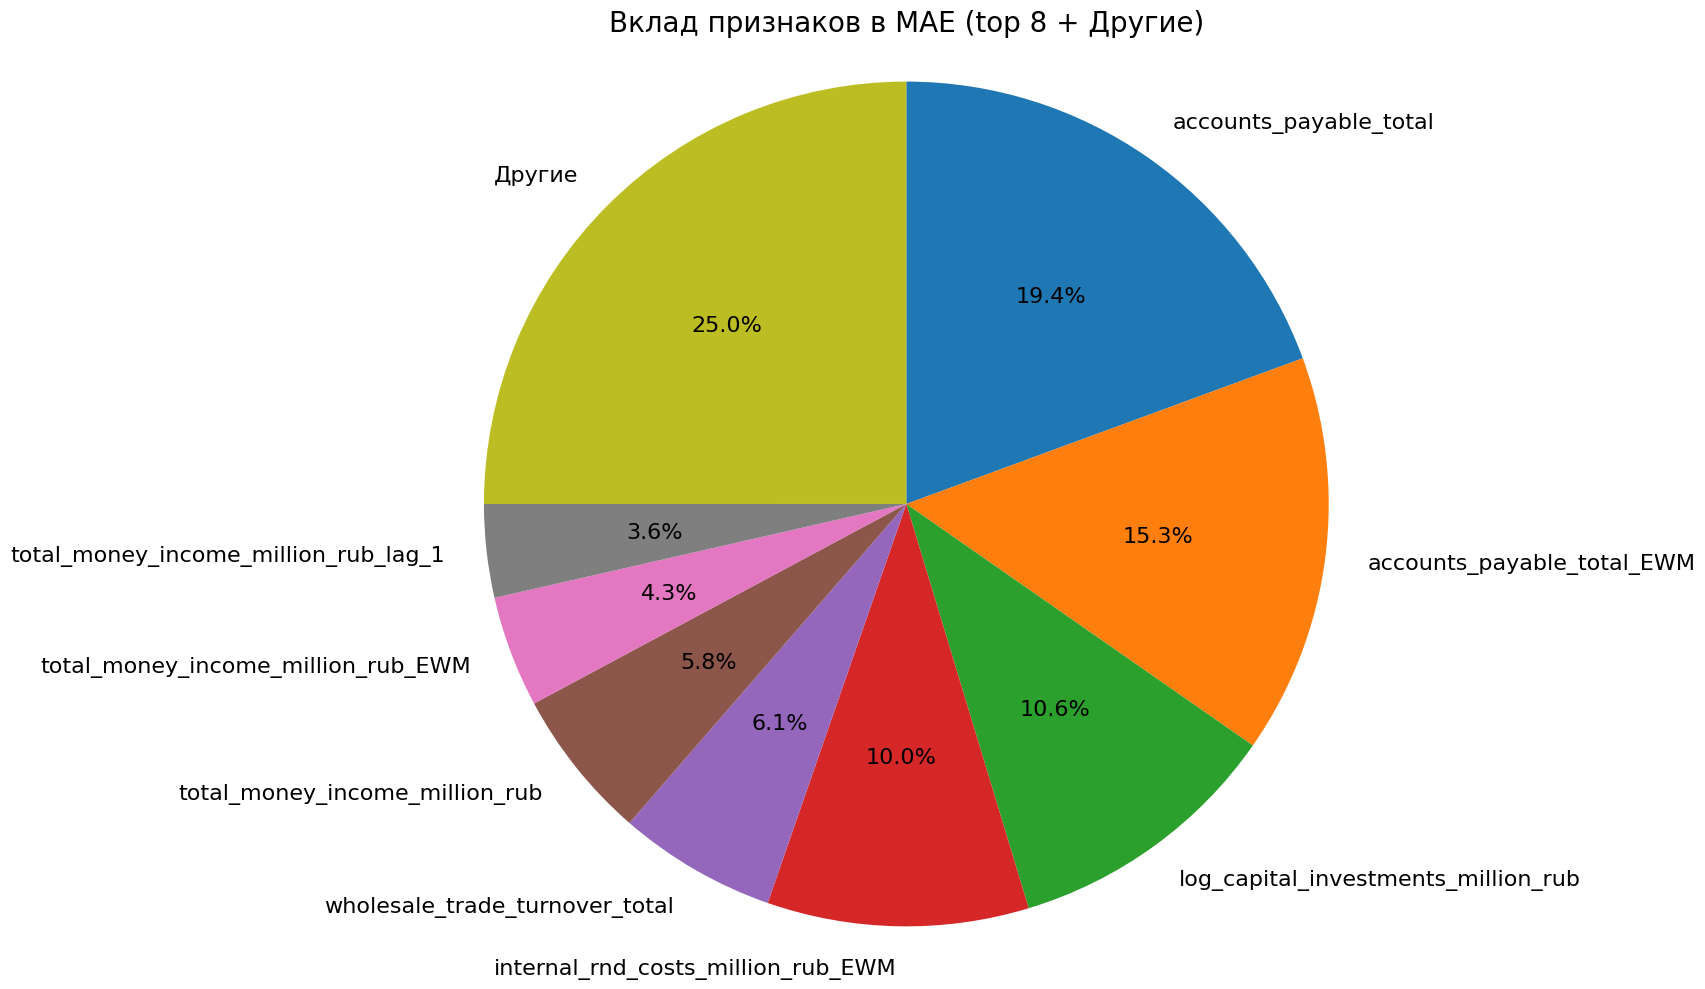

In [21]:
# Cell: 21
TOP_K = 8
N_REPEATS = 10
VERBOSE = True

if 'val_loader' not in globals() or val_loader is None:
    raise RuntimeError("val_loader отсутствует или None — подготовьте валидатор (val_loader) перед запуском этой ячейки.")

if 'model' not in globals():
    raise RuntimeError("model не найден в текущем пространстве имён.")

if 'scaler_y' not in globals():
    raise RuntimeError("scaler_y не найден (нужен для inverse_transform).")

model.eval()
ys_list, yps_list = [], []
with torch.no_grad():
    for batch in val_loader:
        X = batch['X'].to(device)
        Y = batch['Y'].to(device)
        region = batch.get("region", None)
        if isinstance(region, torch.Tensor):
            region = region.to(device)
        pred = model(X, region=region)
        ys_list.append(Y.cpu().numpy())
        yps_list.append(pred.cpu().numpy())

ys_all_scaled = np.concatenate(ys_list, axis=0)
yps_all_scaled = np.concatenate(yps_list, axis=0)

n, h = ys_all_scaled.shape
ys_all_log = scaler_y.inverse_transform(ys_all_scaled.reshape(-1,1)).reshape(n,h)
yps_all_log = scaler_y.inverse_transform(yps_all_scaled.reshape(-1,1)).reshape(n,h)

ys_all_real = np.expm1(ys_all_log)
yps_all_real = np.expm1(yps_all_log)

baseline_mae = np.mean(np.abs(ys_all_real - yps_all_real))
if VERBOSE:
    print(f"Baseline MAE (real, averaged over все окна и горизонты): {baseline_mae:.6f}")

first_batch = None
for batch in val_loader:
    first_batch = batch
    break

X_sample = first_batch['X']
X_shape = tuple(X_sample.shape)
if len(X_shape) == 3:
    _, seq_len, n_features = X_shape
elif len(X_shape) == 2:
    _, n_features = X_shape
    seq_len = 1
else:
    raise RuntimeError(f"Неожиданная форма batch['X']: {X_shape}")

if 'features' not in globals():
    raise RuntimeError("Переменная 'features' не найдена — в ней должны быть имена признаков.")

feat_names = list(features)

if len(feat_names) != n_features:
    raise RuntimeError(
        f"Размер features ({len(feat_names)}) != количеству признаков в X ({n_features}). "
        "Проверьте порядок или длину features."
    )

def mae_with_permuted_feature(feature_idx):
    ys_parts, yps_parts = [], []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            Xb = batch['X'].to(device)
            Yb = batch['Y'].to(device)
            Xp = Xb.clone()
            B = Xp.size(0)
            if B <= 1:
                if seq_len > 1:
                    perm = torch.randperm(seq_len).to(device)
                    Xp[:, :, feature_idx] = Xp[:, perm, feature_idx]
            else:
                perm_idx = torch.randperm(B).to(device)
                Xp[:, :, feature_idx] = Xp[perm_idx, :, feature_idx]
            region = batch.get("region", None)
            if isinstance(region, torch.Tensor):
                region = region.to(device)
            predp = model(Xp, region=region)
            ys_parts.append(Yb.cpu().numpy())
            yps_parts.append(predp.cpu().numpy())

    ys_scaled = np.concatenate(ys_parts, axis=0)
    yps_scaled = np.concatenate(yps_parts, axis=0)
    ys_log = scaler_y.inverse_transform(ys_scaled.reshape(-1,1)).reshape(-1, h)
    yps_log = scaler_y.inverse_transform(yps_scaled.reshape(-1,1)).reshape(-1, h)
    ys_real = np.expm1(ys_log)
    yps_real = np.expm1(yps_log)
    mae = np.mean(np.abs(ys_real - yps_real))
    return mae

importances = np.zeros(n_features, dtype=float)
for i in range(n_features):
    vals = []
    for _ in range(N_REPEATS):
        mae_perm = mae_with_permuted_feature(i)
        vals.append(mae_perm)
    mae_perm_avg = float(np.mean(vals))
    importance = mae_perm_avg - baseline_mae
    importances[i] = max(0.0, importance)

total_imp = importances.sum()
if total_imp == 0:
    percent = np.zeros_like(importances)
else:
    percent = importances / total_imp * 100.0

df = pd.DataFrame({
    'feature': feat_names,
    'importance': importances,
    'percent': percent
}).sort_values('importance', ascending=False).reset_index(drop=True)

K = int(TOP_K)
top_df = df.head(K).copy()
others_sum = df['importance'].iloc[K:].sum()
others_pct = df['percent'].iloc[K:].sum()
if others_sum > 0:
    top_df = pd.concat([
        top_df,
        pd.DataFrame([{'feature': 'Другие', 'importance': others_sum, 'percent': others_pct}])
    ], ignore_index=True)


plt.figure(figsize=(16, 10))
labels = top_df['feature'].tolist()
sizes = top_df['importance'].tolist()

plt.pie(sizes, 
        labels=labels, 
        autopct='%1.1f%%',
        startangle=90, 
        counterclock=False,
        textprops={'fontsize': 16})

plt.title(f"Вклад признаков в MAE (top {K} + Другие)", fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.savefig(f"Вклад_признаков_в_MAE.png")
plt.show()

In [22]:
# Cell 22
df.to_excel("Вклад_признаков_в_MAE.xlsx")